## Задача бинарной классификации. Определение положительных и отрицательных отзывов на фильмы.

Отзывы делятся на:
- положительные (оценка >= 7) 1 - отзыв положительные
- отрицательные (оценка <= 4) 0 - отзыв отрицательные

Размер набора данных 50000 отзывов:
- Для обучения 25000
- Для тестирования 25000

Количество положительных и отрицательных отзывов одинаковое.

https://ai.stanford.edu/~amaas/data/sentiment/

https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf

#Импорт библиотек

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, LSTM
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline

## Загружаем данные

In [ ]:
max_words=10000 #Используем самые популярные 10000 слов, можно больше

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

17464789/17464789 [==============================] - 0s 0us/step


## Просмотр данных

Рецензия

In [ ]:
x_train[11] #Токенизация слов

[1,
 54,
 13,
 1610,
 14,
 20,
 13,
 69,
 55,
 364,
 1398,
 21,
 54,
 13,
 219,
 12,
 13,
 1706,
 15,
 4,
 20,
 16,
 329,
 6,
 176,
 329,
 74,
 51,
 13,
 873,
 4,
 156,
 71,
 78,
 4,
 7412,
 322,
 16,
 31,
 7,
 4,
 249,
 4,
 65,
 16,
 38,
 379,
 12,
 100,
 157,
 18,
 6,
 910,
 20,
 549,
 18,
 4,
 1496,
 21,
 14,
 31,
 9,
 24,
 6,
 212,
 12,
 9,
 6,
 1322,
 991,
 7,
 3002,
 4,
 425,
 9,
 73,
 2218,
 549,
 18,
 31,
 155,
 36,
 100,
 763,
 379,
 20,
 103,
 351,
 5308,
 13,
 202,
 12,
 2241,
 5,
 6,
 320,
 46,
 7,
 457]

In [ ]:
y_train[11] #Ответ рецензии 1 - положительный, 0 - отрицательный

0

В наборе данных IMDB используется частотное кодирование слов. Загрузим словарь, который использовался для кодирования. Теперь можно раскодировать слова.

In [ ]:
word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

In [ ]:
# Преобразуем словарь, чтобы по номеру получать слово
reverse_word_index = dict()
for key, value in word_index.items():
    reverse_word_index[value] = key

In [ ]:
# Печатаем 35 самых частых слов
for i in range(1, 36):
    print(i, '---->', reverse_word_index[i])


1 ----> the
2 ----> and
3 ----> a
4 ----> of
5 ----> to
6 ----> is
7 ----> br
8 ----> in
9 ----> it
10 ----> i
11 ----> this
12 ----> that
13 ----> was
14 ----> as
15 ----> for
16 ----> with
17 ----> movie
18 ----> but
19 ----> film
20 ----> on
21 ----> not
22 ----> you
23 ----> are
24 ----> his
25 ----> have
26 ----> he
27 ----> be
28 ----> one
29 ----> all
30 ----> at
31 ----> by
32 ----> an
33 ----> they
34 ----> who
35 ----> so


Теперь можно раскодировать весь отзыв по индексу

Служебные коды:
- 0 - символ заполнитель
- 1 - начало отзыва
- 2 - неизвестное слово

In [ ]:
index = 222
message = ''
for code in x_train[index]:
    word = reverse_word_index.get(code - 3, '!') # ! - Это замена символа для тех слов, которые не вошли в наш лимит, в моём случае, которые не вошли в 10000 выборки в самом начале
    message += word + ' '
message

"! movies of course i'd get an answer like ! don't make good movies didn't you see ! ! ! of course this is ludicrous as it is one example of a ! movie and probably the only example that anyone nowadays would be likely to see br br an example of movies that are ! not just slow moving are the ! film ! or david lynch's the straight story i hate to promote the ! language as it is endlessly and unfairly promoted and shoved down the throats of non ! ! but for the sake of calling a spade a spade i say that ! is a very good movie these movies rely heavily on what hitchcock called ! ! images without words are used to convey the story but i bend the definition a bit for the sake of these two movies in that these movies use images without words to convey the mood of the movie and they do it very well ! thinks that if they simply take sweeping shots of the landscape then they have established the mood br br and what's with so many ! movies featuring a dying mother or grandmother "

## Подготовка данных для обучения

In [ ]:
maxlen = 200 #Максимальная длинна слов в отзыве, если слов менее 200, мы подставляем нули. Так-как нам нужна одинковая длинна, мы подгоняем все отзывы к 200 словам

In [ ]:
# В функции обрезаем, если более 200 и добавляем символ заполнитель (0), если менее 200
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post')

In [ ]:
x_train[1]

array([   1,  194, 1153,  194, 8255,   78,  228,    5,    6, 1463, 4369,
       5012,  134,   26,    4,  715,    8,  118, 1634,   14,  394,   20,
         13,  119,  954,  189,  102,    5,  207,  110, 3103,   21,   14,
         69,  188,    8,   30,   23,    7,    4,  249,  126,   93,    4,
        114,    9, 2300, 1523,    5,  647,    4,  116,    9,   35, 8163,
          4,  229,    9,  340, 1322,    4,  118,    9,    4,  130, 4901,
         19,    4, 1002,    5,   89,   29,  952,   46,   37,    4,  455,
          9,   45,   43,   38, 1543, 1905,  398,    4, 1649,   26, 6853,
          5,  163,   11, 3215,    2,    4, 1153,    9,  194,  775,    7,
       8255,    2,  349, 2637,  148,  605,    2, 8003,   15,  123,  125,
         68,    2, 6853,   15,  349,  165, 4362,   98,    5,    4,  228,
          9,   43,    2, 1157,   15,  299,  120,    5,  120,  174,   11,
        220,  175,  136,   50,    9, 4373,  228, 8255,    5,    2,  656,
        245, 2350,    5,    4, 9837,  131,  152,  4

In [ ]:
y_train[1]

0

## Создание нейронной сети

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 2, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/15
176/176 [==============================] - 25s 120ms/step - loss: 0.6899 - accuracy: 0.5409 - val_loss: 0.6784 - val_accuracy: 0.6440
Epoch 2/15
176/176 [==============================] - 12s 71ms/step - loss: 0.6139 - accuracy: 0.7309 - val_loss: 0.5317 - val_accuracy: 0.7780
Epoch 3/15
176/176 [==============================] - 10s 55ms/step - loss: 0.4475 - accuracy: 0.8284 - val_loss: 0.4011 - val_accuracy: 0.8440
Epoch 4/15
176/176 [==============================] - 5s 27ms/step - loss: 0.3473 - accuracy: 0.8699 - val_loss: 0.3476 - val_accuracy: 0.8596
Epoch 5/15
176/176 [==============================] - 5s 28ms/step - loss: 0.2959 - accuracy: 0.8888 - val_loss: 0.3212 - val_accuracy: 0.8672
Epoch 6/15
176/176 [==============================] - 3s 17ms/step - loss: 0.2666 - accuracy: 0.8993 - val_loss: 0.3060 - val_accuracy: 0.8780
Epoch 7/15
176/176 [==============================] - 3s 14ms/step - loss: 0.2429 - accuracy: 0.9100 - val_loss: 0.2997 - val_accuracy: 0.

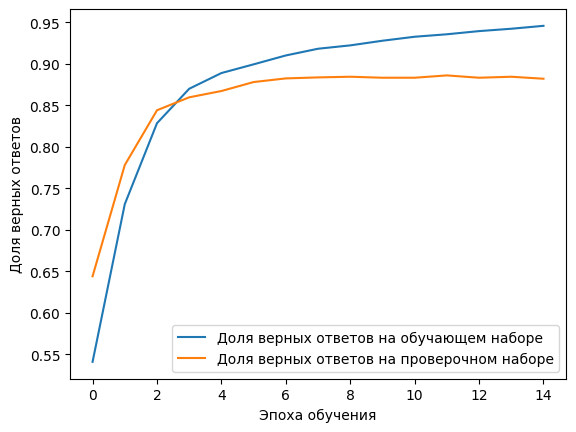

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Проверяем работу сети на тестовом наборе данных

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 2s 2ms/step - loss: 0.3011 - accuracy: 0.8732


## Исследуем обученное плотное векторное представление слов

**Получаем матрицу плотных векторных представлений слов**

In [ ]:
embedding_matrix = model.layers[0].get_weights()[0]

In [ ]:
embedding_matrix[:5]

array([[-0.01777539, -0.0131581 ],
       [ 0.11847067, -0.09112346],
       [ 0.02529939, -0.03059318],
       [-0.04464612, -0.04640687],
       [-0.0254386 ,  0.02169847]], dtype=float32)

**Загружаем словарь с номерами слов**

In [ ]:
word_index_org = imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


Дополняем словарь служебными символами

In [ ]:
word_index = dict()
for word,number in word_index_org.items():
    word_index[word] = number + 3
word_index["<Заполнитель>"] = 0
word_index["<Начало последовательности>"] = 1
word_index["<Неизвестное слово>"] = 2
word_index["<Не используется>"] = 3

**Ищем векторы для слов**

In [ ]:
word = 'good'
word_number = word_index[word]
print('Номер слова', word_number)
print('Вектор для слова', embedding_matrix[word_number])

Номер слова 52
Вектор для слова [-0.1816714   0.15330541]


##Записываем плотные векторные представления в файл для более удобного просмотре, если нужно. Если не нужно, то просто пропускаем эти ячейки и переходим к графическим представлениям.

**Составляем реверсивный словарь токенов (слов)**

In [ ]:
reverse_word_index = dict()
for key, value in word_index.items():
    reverse_word_index[value] = key

In [ ]:
filename = 'imdb_vectors_embeddings.csv'

In [ ]:
with open(filename, 'w') as f:
    for word_num in range(max_words):
      word = reverse_word_index[word_num]
      vec = embedding_matrix[word_num]
      f.write(word + ",")
      f.write(','.join([str(x) for x in vec]) + "\n")

In [ ]:
!head -n 20 $filename

<Заполнитель>,-0.01777539,-0.013158104
<Начало последовательности>,0.11847067,-0.09112346
<Неизвестное слово>,0.025299385,-0.03059318
<Не используется>,-0.04464612,-0.046406865
the,-0.025438601,0.021698471
and,-0.060983103,0.06998279
a,0.014185479,0.008022791
of,-0.0023132083,-0.04298501
to,0.0057043848,0.0030206074
is,-0.048966784,0.04388928
br,0.040577874,-0.011671463
in,-0.01598009,0.004152923
it,-0.054415144,0.064467356
i,-0.02165479,0.020052116
this,0.012843463,-0.016580343
that,-0.021698797,-0.03330211
was,0.07178332,-0.018799169
as,-0.031185336,-0.019581955
for,0.0382516,0.022878649
with,-0.05132289,-0.06777638


**Сохраняем файл на локальный компьютер**

In [ ]:
files.download('imdb_vectors_embeddings.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Визуализация плотных векторных представлений слов

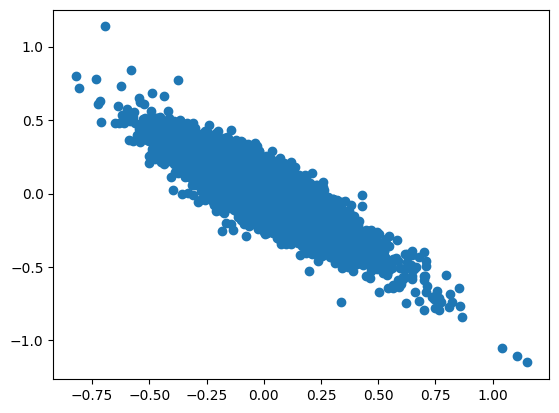

In [ ]:
plt.scatter(embedding_matrix[:,0], embedding_matrix[:,1])

Выбираем коды слов, по которым можно определить тональность отзыва

In [ ]:
review = ['brilliant', 'fantastic', 'amazing', 'good',
          'bad', 'awful','crap', 'terrible', 'trash', 'worst']
enc_review = []
for word in review:
    enc_review.append(word_index[word])
enc_review

[530, 777, 480, 52, 78, 373, 595, 394, 1157, 249]

Получаем векторное представление интересующих нас слов

In [ ]:
review_vectors = embedding_matrix[enc_review]
review_vectors

array([[-0.54336655,  0.4400252 ],
       [-0.5972832 ,  0.502111  ],
       [-0.65161186,  0.47856906],
       [-0.1816714 ,  0.15330541],
       [ 0.5124018 , -0.41964096],
       [ 1.0418983 , -1.0483547 ],
       [ 0.5135946 , -0.4532183 ],
       [ 0.742709  , -0.717472  ],
       [ 0.19706315, -0.30703217],
       [ 1.1488132 , -1.1497608 ]], dtype=float32)

Визуализация обученного плотного векторного представления слов, по которым можно определить эмоциональную окраску текста

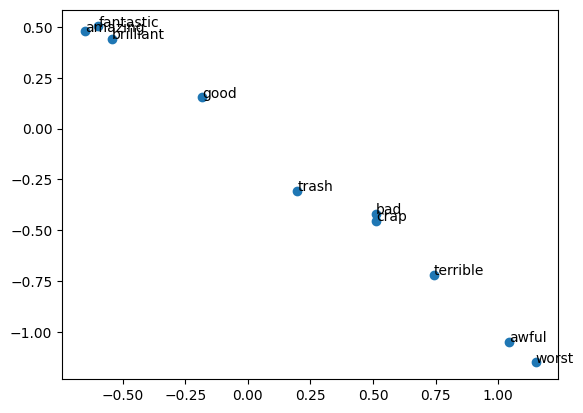

In [ ]:
plt.scatter(review_vectors[:,0], review_vectors[:,1])
for i, txt in enumerate(review):
    plt.annotate(txt, (review_vectors[i,0], review_vectors[i,1]))

#Представление тональности текста в формате one hot encoding

In [ ]:
x_train[3]

array([   4,  341,    7,   27,  846,   10,   10,   29,    9, 1906,    8,
         97,    6,  236,    2, 1311,    8,    4,    2,    7,   31,    7,
          2,   91,    2, 3987,   70,    4,  882,   30,  579,   42,    9,
         12,   32,   11,  537,   10,   10,   11,   14,   65,   44,  537,
         75,    2, 1775, 3353,    2, 1846,    4,    2,    7,  154,    5,
          4,  518,   53,    2,    2,    7, 3211,  882,   11,  399,   38,
         75,  257, 3807,   19,    2,   17,   29,  456,    4,   65,    7,
         27,  205,  113,   10,   10,    2,    4,    2,    2,    9,  242,
          4,   91, 1202,    2,    5, 2070,  307,   22,    7, 5168,  126,
         93,   40,    2,   13,  188, 1076, 3222,   19,    4,    2,    7,
       2348,  537,   23,   53,  537,   21,   82,   40,    2,   13,    2,
         14,  280,   13,  219,    4,    2,  431,  758,  859,    4,  953,
       1052,    2,    7, 5991,    5,   94,   40,   25,  238,   60,    2,
          4,    2,  804,    2,    7,    4, 9941,  1

Так как у нас все отзывы предствлены в числовом формате, нам нужно преобразовать массив в вектор one hot encoding

In [ ]:
def vectorize_sequences(sequences, dimension=10000): #Длинна вектора 10000
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. #Там, где у нас будет слово, ставим 1, а где нет ничего - вектор заполняется нулями
    return results

In [ ]:
x_train = vectorize_sequences(x_train, max_words)
x_test = vectorize_sequences(x_test, max_words)

In [ ]:
x_train[0][:50]

array([0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.])

В таком формате отзывов мы теряем позицию и кол-во раз встречаемых слов, способ работы похож на метод Bag of words (мешок слов)

In [ ]:
len(x_train[0])

10000

In [ ]:
y_train[0]

1

In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(max_words,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/10
176/176 [==============================] - 3s 8ms/step - loss: 0.3498 - accuracy: 0.8489 - val_loss: 0.2978 - val_accuracy: 0.8780
Epoch 2/10
176/176 [==============================] - 1s 6ms/step - loss: 0.1756 - accuracy: 0.9331 - val_loss: 0.3433 - val_accuracy: 0.8656
Epoch 3/10
176/176 [==============================] - 1s 6ms/step - loss: 0.0920 - accuracy: 0.9681 - val_loss: 0.3995 - val_accuracy: 0.8696
Epoch 4/10
176/176 [==============================] - 1s 6ms/step - loss: 0.0257 - accuracy: 0.9932 - val_loss: 0.5199 - val_accuracy: 0.8712
Epoch 5/10
176/176 [==============================] - 1s 6ms/step - loss: 0.0037 - accuracy: 0.9996 - val_loss: 0.6668 - val_accuracy: 0.8680
Epoch 6/10
176/176 [==============================] - 1s 6ms/step - loss: 6.7664e-04 - accuracy: 0.9999 - val_loss: 0.7484 - val_accuracy: 0.8696
Epoch 7/10
176/176 [==============================] - 1s 8ms/step - loss: 2.6529e-04 - accuracy: 1.0000 - val_loss: 0.8092 - val_accuracy: 0.870

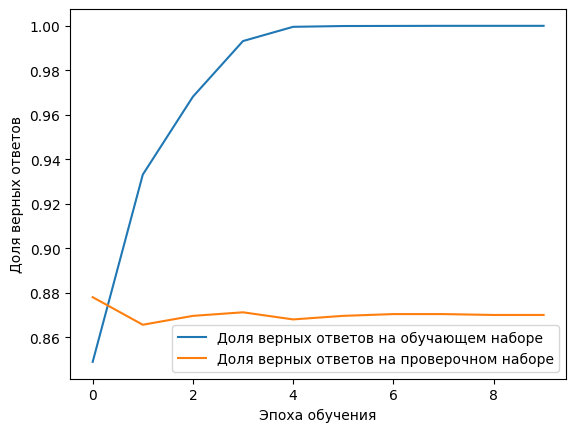

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 2s 3ms/step - loss: 1.0508 - accuracy: 0.8527


In [ ]:
print("Доля верных ответов на тестовых данных:", round(scores[1] * 100), '%')

Доля верных ответов на тестовых данных: 85 %


На графике видно, что сразу точность на высоком уровне, но потом падает из-за переобучения

# Определение тональности текста с помощью сети LSTM

In [ ]:
max_words=10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)
maxlen = 200
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
x_train[5002]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    1,  103,   51,   13,  197,   16,    6, 4796,
        239,    7,  107,  555,   11,  132,   39, 8921, 1872,  138,   16,
       4093, 1768, 2959,   34, 1620,    2,   11,    4,  755,   12,   43,
        286,    4,  172,  209,    2,    5, 5938,   17, 1000,   34, 1768,
        279,   29, 3892,   89,  338,    4,  114,   16, 1240, 1747,  103,
       3844, 3819,    8,  169, 2875,  112, 7062,   34,  160,  132,   29,
        100,   24,  535,  101,  250,    8,  858,   15,  196,   19,   57,
       3154,   39,   90,    5,   24,  169, 3533,   

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 8, input_length=maxlen))
model.add(LSTM(32, recurrent_dropout = 0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/15
176/176 [==============================] - 129s 714ms/step - loss: 0.5317 - accuracy: 0.7308 - val_loss: 0.3550 - val_accuracy: 0.8584
Epoch 2/15
176/176 [==============================] - 114s 648ms/step - loss: 0.2945 - accuracy: 0.8878 - val_loss: 0.3293 - val_accuracy: 0.8764
Epoch 3/15
176/176 [==============================] - 107s 611ms/step - loss: 0.2280 - accuracy: 0.9168 - val_loss: 0.2915 - val_accuracy: 0.8860
Epoch 4/15
176/176 [==============================] - 111s 629ms/step - loss: 0.1788 - accuracy: 0.9360 - val_loss: 0.3013 - val_accuracy: 0.8852
Epoch 5/15
176/176 [==============================] - 103s 587ms/step - loss: 0.1476 - accuracy: 0.9471 - val_loss: 0.4089 - val_accuracy: 0.8700
Epoch 6/15
176/176 [==============================] - 104s 592ms/step - loss: 0.1237 - accuracy: 0.9581 - val_loss: 0.3798 - val_accuracy: 0.8716
Epoch 7/15
176/176 [==============================] - 106s 602ms/step - loss: 0.1116 - accuracy: 0.9644 - val_loss: 0.3648 -

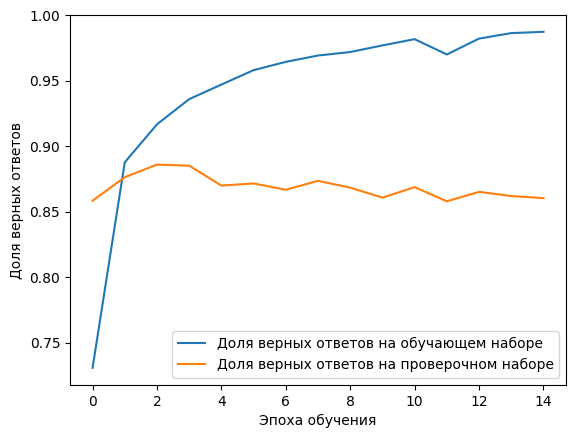

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)

782/782 [==============================] - 52s 67ms/step - loss: 0.8080 - accuracy: 0.8371


In [ ]:
print("Доля верных ответов на тестовых данных:", round(scores[1] * 100), '%')

Доля верных ответов на тестовых данных: 84 %


Как видно из графика, после 3 эпохи идёт переобучение, хотя точность неплохая